In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque, defaultdict

In [44]:
# DAG provided in appendix A
dag = {
    (0, 30), (1, 0), (2, 7), (3, 2), (4, 1), (5, 15), (6, 5), (7, 6), (8, 7), (9, 8), (10, 0), (11, 4), (12, 11), (13, 12), (16, 14), (14, 10), (15, 4), (16, 15), (17, 16), (18, 17), (19, 18), (20, 17), (21, 20), (22, 21), (23, 4), (24, 23), (25, 24), (26, 25), (27, 25), (28, 26), (28, 27), (29, 3), (29, 9),
    (29, 13), (29, 19), (29, 22), (29, 28)
}

# processing times provided in Appendix A
p = [3, 10, 2, 2, 5, 2, 14, 5, 6, 5, 5, 2, 3, 3, 5, 6, 6, 6, 2, 3, 2, 3, 14, 5, 18, 10, 2, 3, 6, 2, 10]

# due dates provided in Appendix A
d = [172, 82, 18, 61, 93, 71, 217, 295, 290, 287, 253, 307, 279, 73, 355, 34, 233, 77, 88, 122, 71, 181, 340, 141, 209, 217, 256, 144, 307, 329, 269]

num_nodes = len(p)

# initial solution for tabu search algorithm for given DAG
initial_solution = [29, 28, 22, 9, 8, 13, 12, 11, 3, 19, 21, 2, 26, 27, 7, 6, 18, 20, 25, 17, 24, 16, 14, 5, 23, 15, 4, 10, 1, 0, 30]

In [4]:
# finding all nodes that a given node can reach either directly or transitively
def get_all_reachable(dag):
    reachable = set()
    nodes = list(range(num_nodes))

    # marking all nodes reached from a direct edge as reachable
    for (u, v) in dag:
        reachable.add((u, v))

    # Floyd-Warshall algorithm
    for i in nodes:
        for j in nodes:
            for k in nodes:
                # transitive reachability, i.e. if i can reach j & j can reach k, i can reach k 
                if (i, j) in reachable and (j, k) in reachable:
                    reachable.add((i, k))

    return reachable

reachable = get_all_reachable(dag)

In [30]:
def generate_initial_solution(dag):
    # generating an initial solution using a topical sort
    num_edges_into_node = {}
    all_nodes = set(list(range(num_nodes)))
    
    # initializing dictionary
    for node in all_nodes:
        num_edges_into_node[node] = 0
    
    for (u, v) in dag:
        num_edges_into_node[v] += 1
        
    # finding all nodes with no edges into it
    processing_queue = deque([node for node in all_nodes if num_edges_into_node[node] == 0])
    initial_solution = []
    while processing_queue:
        node = processing_queue.popleft()
        initial_solution.append(node)
        
        for (u, v) in dag:
            if u == node:
                num_edges_into_node[v] -= 1
                if num_edges_into_node[v] == 0:
                    processing_queue.append(v)
    
    does_contain_cycles = len(initial_solution) != len(all_nodes)
    if not does_contain_cycles:
        return initial_solution
    else:
        return [] # if there is a cycle, no way to do tabu search

In [5]:
def lcl_rule(dag, processing_times):
    all_schedules = []
    schedule = []
    return schedule, all_schedules

In [6]:
# checking if we can swap two nodes at positions i, j in a schedule where i < j
def is_valid_swap(schedule, i, j, reachable=reachable):
    u, v = schedule[i], schedule[j]
    return (u, v) not in reachable and (v, u) not in reachable # if either u depends on v or v depends on u, cannot swap nodes

def generate_neighboring_schedule(schedule, tabu_list, reachable=reachable):
    neighboring_schedule = []
    i_list = list(range(num_nodes))
    random.shuffle(i_list)
    j_list = list(range(num_nodes))
    random.shuffle(j_list)
    tabu_pairs = []
    for tabu in tabu_list:
        tabu_pairs.append((tabu[0], tabu[1]))

    # shuffle lists so we don't overweight swaps early in schedule
    for i in i_list:
        for j in j_list:
            if is_valid_swap(schedule, i, j, reachable) and (i, j) not in tabu_pairs:
                neighboring_schedule = schedule[:]
                neighboring_schedule[i], neighboring_schedule[j] = neighboring_schedule[j], neighboring_schedule[i]
                return neighboring_schedule, (i, j)
                
    # if no valid neighbors, we are done            
    return neighboring_schedule, (-1, -1)

def evaluate_tardiness(schedule, p, d):
    total_tardiness = 0
    current_time = 0
    
    for job in schedule:
        completion_time = current_time + p[job-1] # -1 because 0 indexing
        tardiness = max(0, completion_time - d[job-1])
        total_tardiness += tardiness
        current_time = completion_time
    
    return total_tardiness

def update_tabu_list(tabu_list, max_length):
    updated_list = deque(maxlen=max_length)
    for tabu in tabu_list:
        updated_tabu = (tabu[0], tabu[1], tabu[2] + 1) # increase age of each item in tabu list
        if updated_tabu[2] <= max_length: # only keep items under a certain number of iterations
            updated_list.append(updated_tabu)

    return updated_list

def tabu_search(dag, p, d, num_iterations=100, tolerance=10, tabu_list_length=20, use_default_initial_solution=True):
    # initializing parameters
    tabu_list = deque(maxlen=tabu_list_length)
    reachable = get_all_reachable(dag)
    current_schedule = initial_solution if use_default_initial_solution else generate_initial_solution(dag)
    current_tardiness = evaluate_tardiness(current_schedule, p, d)
    best_schedule = current_schedule
    best_tardiness = current_tardiness
    
    for iteration in range(num_iterations):
        # print(f"Iteration: {iteration}")
        neighbor_schedule, (i, j) = generate_neighboring_schedule(current_schedule, tabu_list, reachable)
        
        if not neighbor_schedule: # if no valid neighbors, we are done
            return best_schedule, best_tardiness
        
        neighbor_tardiness = evaluate_tardiness(neighbor_schedule, p, d)
        delta = current_tardiness - neighbor_tardiness
        if delta > -1 * tolerance or neighbor_tardiness < best_tardiness:
            current_schedule, current_tardiness = neighbor_schedule, neighbor_tardiness
            tabu_list = update_tabu_list(tabu_list, tabu_list_length)
            tabu_list.append((i, j, 0))
            if current_tardiness < best_tardiness:
                best_tardiness = current_tardiness
                best_schedule = current_schedule
    
    return best_schedule, best_tardiness

In [7]:
best_schedule, best_tardiness = tabu_search(dag, p, d)
print(best_tardiness)
print(best_schedule)
print(evaluate_tardiness(best_schedule, p, d))

1
[21, 29, 16, 1, 3, 2, 28, 8, 20, 4, 22, 14, 9, 30, 13, 27, 19, 5, 6, 18, 12, 25, 31, 11, 24, 7, 10, 23, 17, 26, 15]
1


In [46]:
print(generate_initial_solution(dag))
print(initial_solution)

[29, 13, 19, 22, 28, 3, 9, 12, 18, 21, 27, 26, 2, 8, 11, 20, 25, 7, 17, 24, 6, 16, 23, 5, 14, 15, 10, 4, 1, 0, 30]
[29, 28, 22, 9, 8, 13, 12, 11, 3, 19, 21, 2, 26, 27, 7, 6, 18, 20, 25, 17, 24, 16, 14, 5, 23, 15, 4, 10, 1, 0, 30]


In [14]:
tolerances = [0, 5, 10, 50, 100, 200, 300]
tabu_list_lengths = [5, 10, 20, 50, 100]
num_iters = [10, 100, 1000, 5000]
samples_to_test = 100

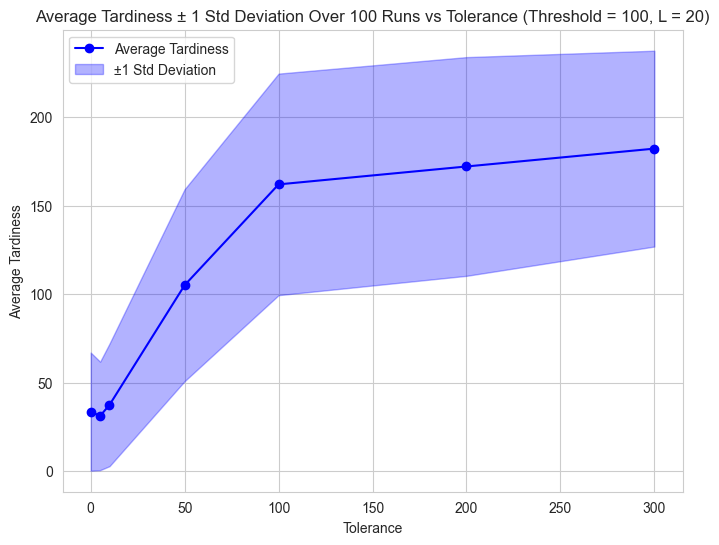

In [47]:
mean_tardiness_at_tolerance = []
std_deviation_tardiness_at_tolerance = []
for tolerance in tolerances:
    best_outcomes = []
    for _ in range(samples_to_test):
        _, best_tardiness = tabu_search(dag, p, d, tolerance=tolerance)
        best_outcomes.append(best_tardiness)
    mean_tardiness_at_tolerance.append(np.array(best_outcomes).mean())
    std_deviation_tardiness_at_tolerance.append(np.array(best_outcomes).std())
    
plt.figure(figsize=(8, 6))
plt.plot(tolerances, mean_tardiness_at_tolerance, marker='o', color='b', label="Average Tardiness")
means = np.array(mean_tardiness_at_tolerance)
stds = np.array(std_deviation_tardiness_at_tolerance)
plt.fill_between(tolerances, means - stds, means + stds, color='blue', alpha=0.3, label="±1 Std Deviation")

# Add labels and title
plt.xlabel('Tolerance')
plt.ylabel('Average Tardiness')
plt.title('Average Tardiness ± 1 Std Deviation Over 100 Runs vs Tolerance (Threshold = 100, L = 20)')

plt.grid(True)
plt.legend()
plt.show()

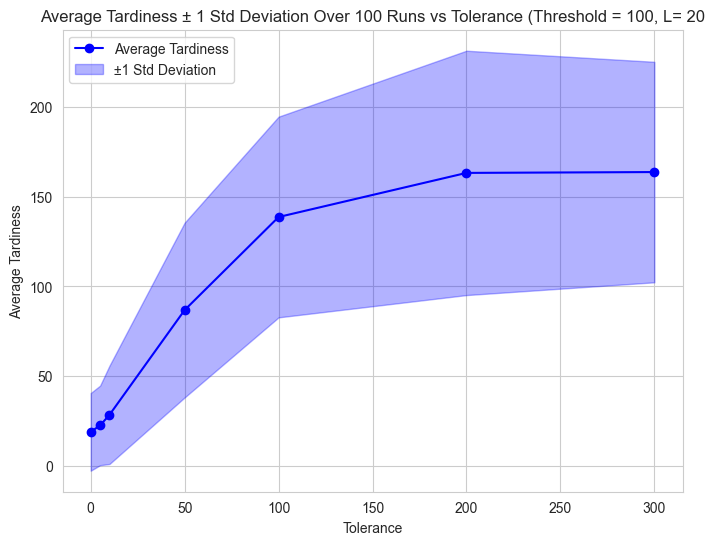

In [13]:
for tabu_len in tabu_list_lengths:
    _, best_tardiness = tabu_search(dag, p, d, tabu_list_length=tabu_len)
    # TODO: plot total tardiness vs tabu list length
    
for num_iter in num_iters:
    _, best_tardiness = tabu_search(dag, p, d, num_iterations=num_iter)
    # TODO: plot total tardiness vs num iterations
    